In [1]:
###################
# from U-Net
###################
import os
import sys
import glob
import random
import datetime
import warnings


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


######################
#from mask-RCNN
######################
import cv2

# to ignore warnings
warnings.filterwarnings('ignore')
#to plot things inline in jupyter
%matplotlib inline

Using TensorFlow backend.


# Loading mask-RCNN

In [11]:
import utils as utl
#from hs_config import hs_config 
#instead of importing the variable (the config file), import the class to be overriden
from hs_config import HsConfig
from bowl_dataset import BowlDataset
import hsModel as modellib
import functions as f


import visualize
from visualize import display_images
from hsModel import log

original had an inference_config in <br>model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR) <br> but i changed it to hs_config (before the weights were for resNet101, but resnet50 was being loaded). 
Also, since the batch size for resNet101 training was 2, here we need to suply to images for prediction.

<font color='red'>The issue with batch size in inference can be resolved by creating a config, that sets the batchsize to 1, this is why they had an inference_config to beging with. </font>


In [12]:
# Override the training config (hsConfig) with a few
# changes for inferencing.
class HsInferenceConfig(HsConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

hs_inference_config = HsInferenceConfig()
hs_inference_config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        512
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               256
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hsConfig
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAININ

In [7]:
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [13]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=hs_inference_config,
                          model_dir=MODEL_DIR)
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
model_path = os.path.join(MODEL_DIR, 'hsconfig20180316T2211/mask_rcnn_hsconfig_0009.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/hooman67/Cell_Nuclei_Segmentation/kaggle-ds-bowl-2018-baseline/logs/hsconfig20180316T2211/mask_rcnn_hsconfig_0009.h5


### testing an image with mask-RCNN

In [27]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [15]:
# load training set
training_set = BowlDataset()
training_set.load_bowl('stage1_train')
training_set.prepare()

In [39]:
print(training_set.class_names)
print(training_set.class_ids)
print(training_set.image_ids[1])
print(training_set.class_info)

['BG', 'nuclei']
[0 1]
1
[{'id': 0, 'name': 'BG', 'source': ''}, {'id': 1, 'name': 'nuclei', 'source': 'bowl'}]


In [18]:
gt_image, gt_image_meta, gt_class_ids, gt_bbox, gt_masks = modellib.load_image_gt(training_set, hs_inference_config, 50)

In [26]:
# Run object detection
results = model.detect([gt_image], verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  112.00000
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:    8.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


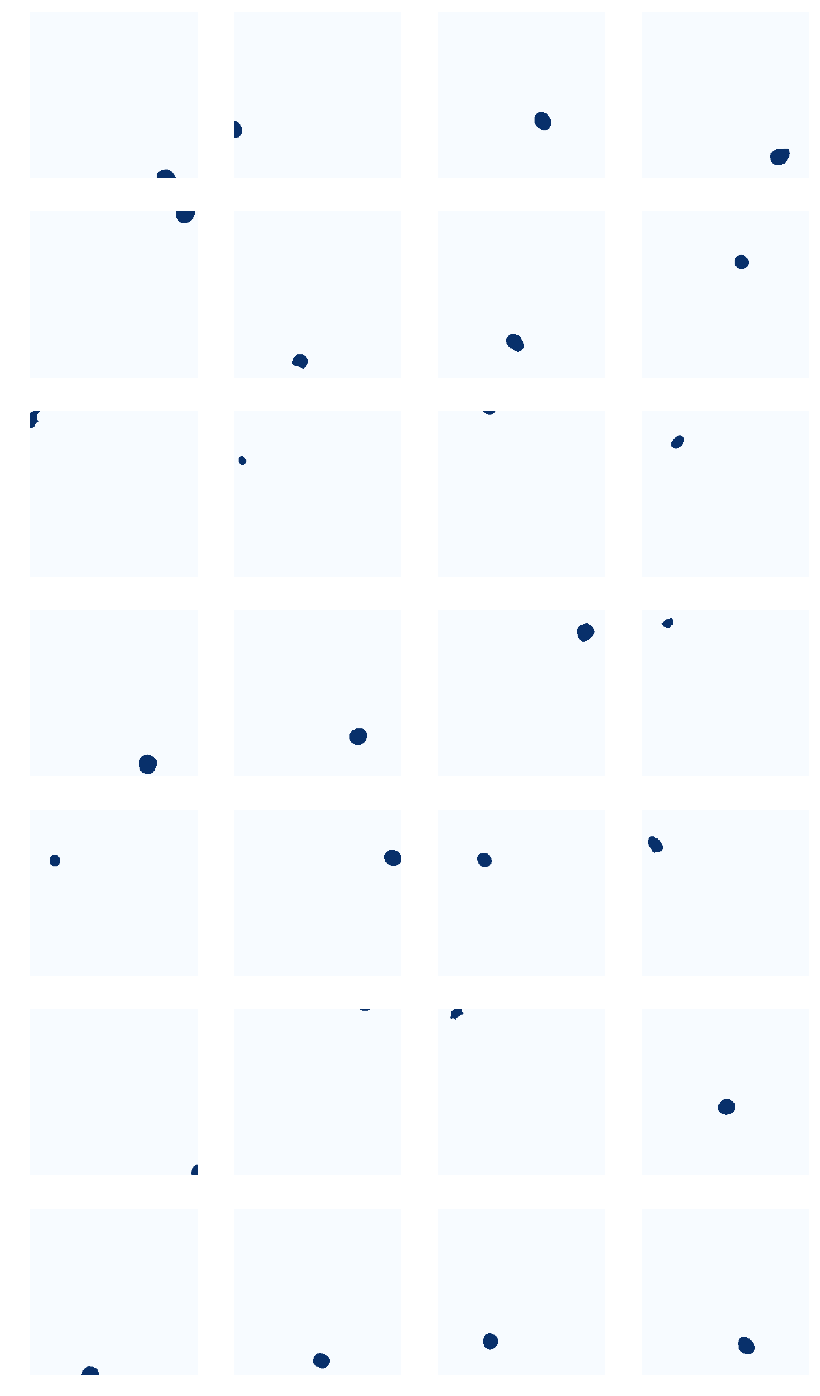

In [78]:
# display original masks
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

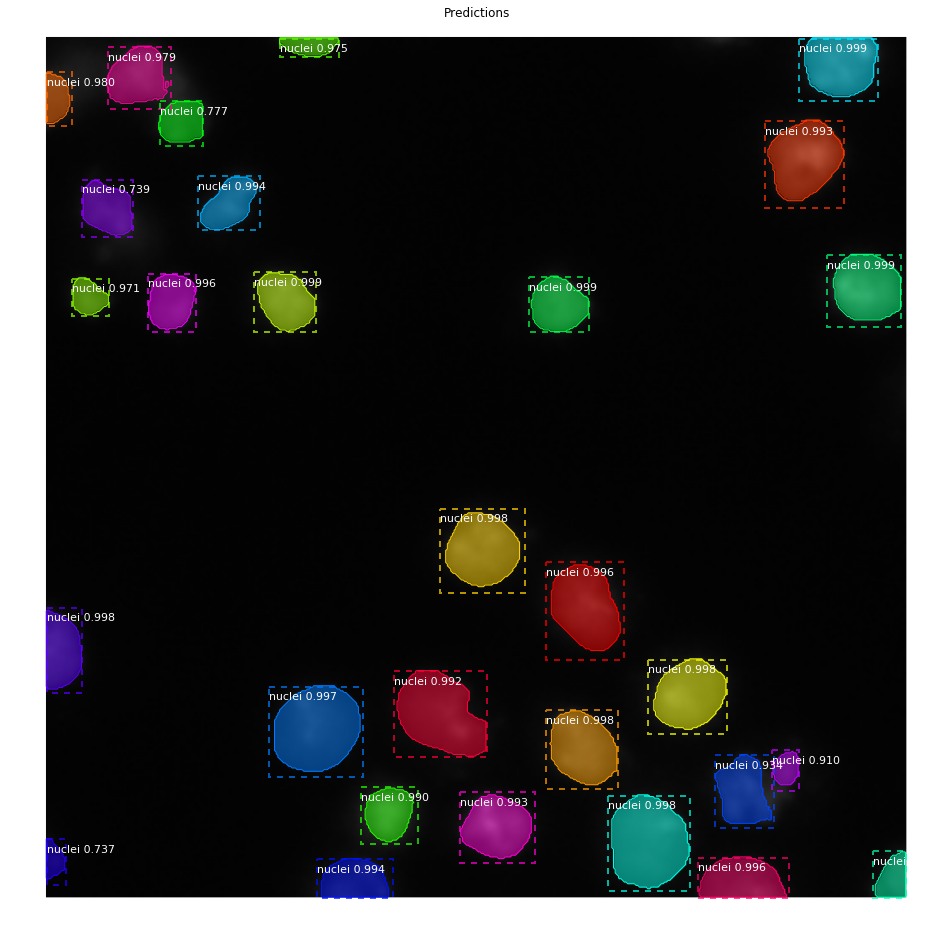

gt_class_id              shape: (28,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (28, 4)               min:    0.00000  max:  512.00000
gt_mask                  shape: (512, 512, 28)        min:    0.00000  max:    1.00000


In [31]:
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(gt_image, r['rois'], r['masks'], r['class_ids'], 
                            training_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_ids)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_masks)

### Precision-Recall

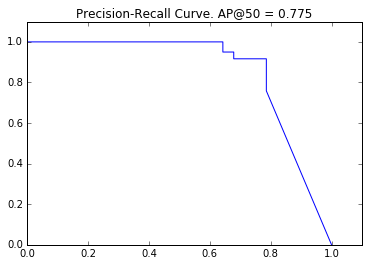

In [33]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utl.compute_ap(gt_bbox, gt_class_ids, gt_masks,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

<font color='red'>HS below shows the pixels that have correctly classified (found) as matches and the pixel that we have missed with no match</font>

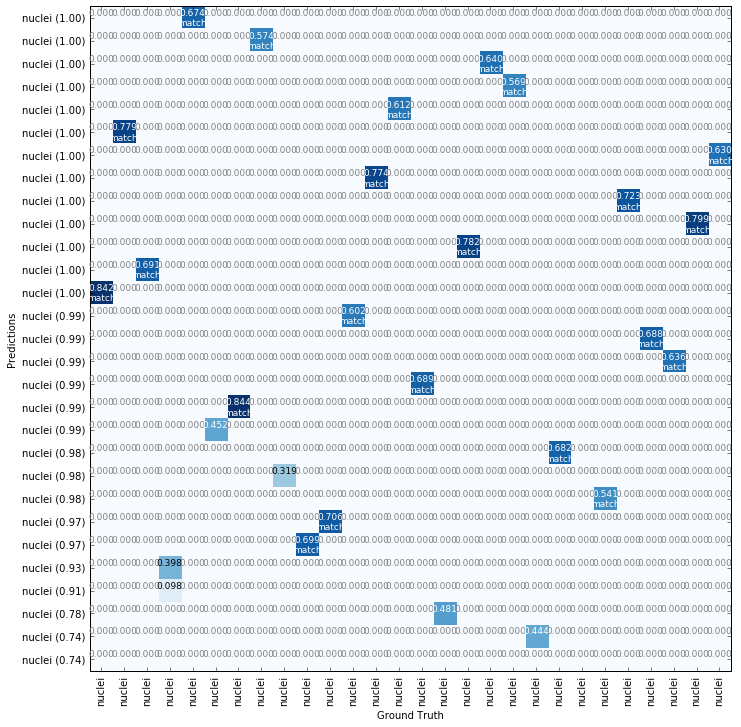

In [40]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_ids, r['class_ids'], r['scores'],
                        overlaps, training_set.class_names)

### Compute mAP @ IoU=50 for above image

In [46]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_id):
    APs = []
    # Load image
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(training_set, hs_inference_config,
                               image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    # Compute AP
    r = results[0]
    AP, precisions, recalls, overlaps =\
        utl.compute_ap(gt_bbox, gt_class_id, gt_mask,
                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    APs.append(AP)
    return APs

# Pick a set of random images
APs = compute_batch_ap(50)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.774999983112


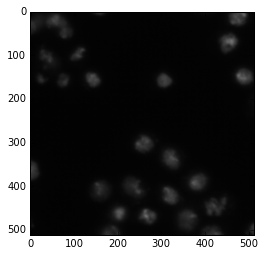

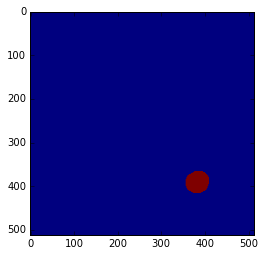

In [41]:
# Desplay the ground truth stuff
plt.figure()
plt.imshow(gt_image)
plt.figure()
plt.imshow(gt_masks[:,:,13])

In [42]:
# hs thsi performs predictions and stores the results in r.
hsResults = model.detect([gt_image], verbose=0)

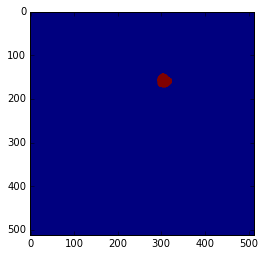

In [44]:
r1 = results[0]
plt.figure()
plt.imshow(r1['masks'][:,:,1])

In [19]:
# For image1 we could only segment 14 out of 28 masks in GT
# gt_image.shape     == (512, 512, 3)
# gt_masks.shape     == (512, 512, 28)
# gt_bbox.shape      == (28, 4)
# gt_class_ids.shape == (28,)

# r['masks'].shape     == (512, 512, 14)
# r['rois'].shape      == (14, 4)
# r['class_ids'].shape == (14,)
# r['scores'].shape    == (14,)

print(r['masks'].shape)
print(gt_masks.shape)
print(r['rois'].shape )
print(gt_bbox.shape)
print(r['class_ids'].shape)
print(gt_class_ids.shape)
print(r['scores'].shape)
print(gt_image.shape)

(512, 512, 41)
(512, 512, 42)
(41, 4)
(42, 4)
(41,)
(42,)
(41,)
(512, 512, 3)


# Investigating Predictions

## Stage 1: Region Proposal Network
### <font color='red'>This is just the output of RPN (suggested bounding boxes) for objects that have been detected but not classified. And no boudning box regression performed yet</font>

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

<font color='red'>HS: <br>image goes through a CNN and gets converetd to a feature map. <br>A bunch of boxes (anchors) are overlayed over the image.<br> RPN returns the probability that each of the boxes contain an object. Anchors with high objectness score (positive anchors) are first refined, then, passed to the stage two to be classified. <br> </font>

### 1.a RPN Targets 

#### <font color='red'>(hs how we scroe the anchors based on the ground truth during training in order to teach RPN to prpose better anchors (boxes)) <font>

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

<font color='red'>To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [49]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(training_set, hs_inference_config,
                               50, use_mini_mask=False)

In [50]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utl.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -5.19860  max:    3.32514
positive_anchors         shape: (28, 4)               min:  -11.31371  max:  512.00000
negative_anchors         shape: (228, 4)              min:   -8.00000  max:  513.65685
neutral anchors          shape: (65216, 4)            min:  -90.50967  max:  538.50967
refined_anchors          shape: (28, 4)               min:   -0.00000  max:  512.00000


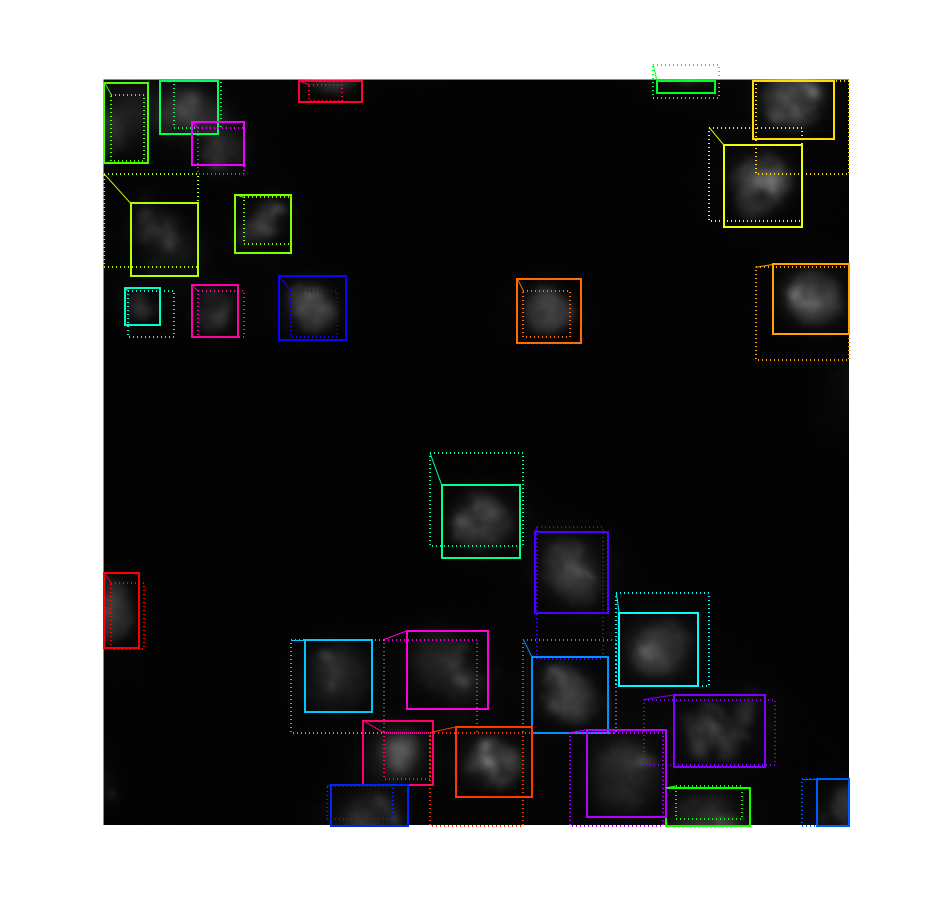

In [51]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [53]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -90.50967  max:  538.50964
refined_anchors          shape: (1, 6000, 4)          min:  -85.72981  max:  591.76001
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:  512.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1708.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


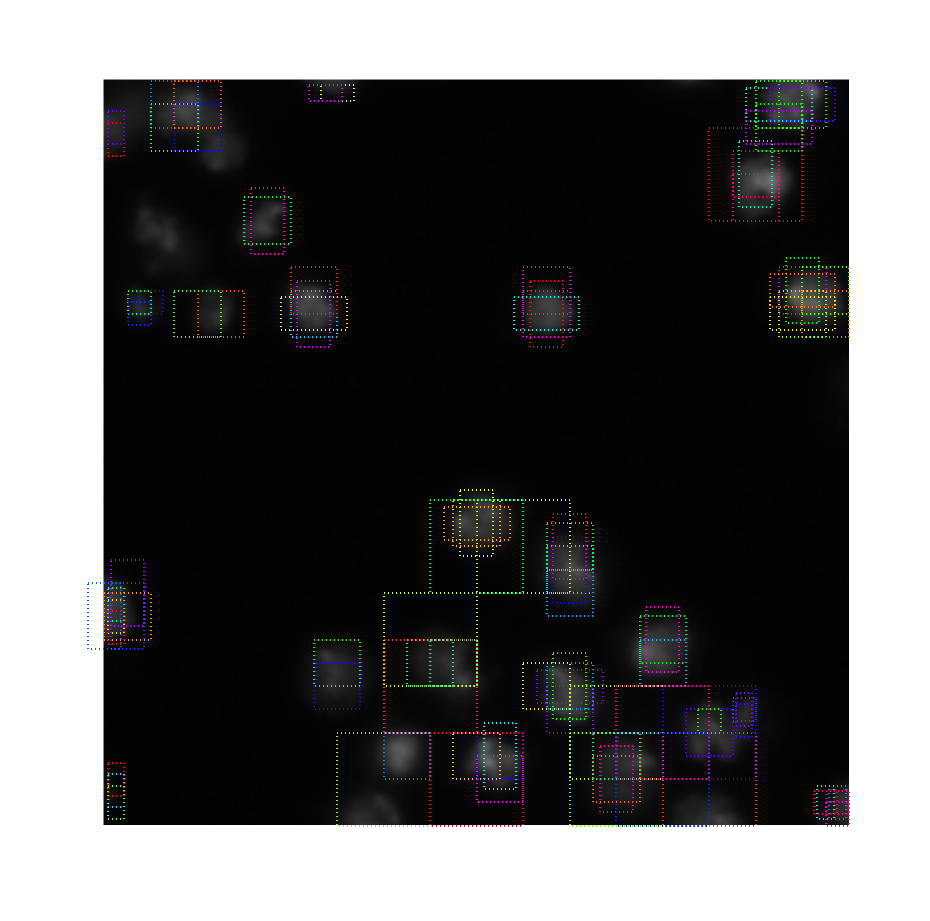

In [54]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

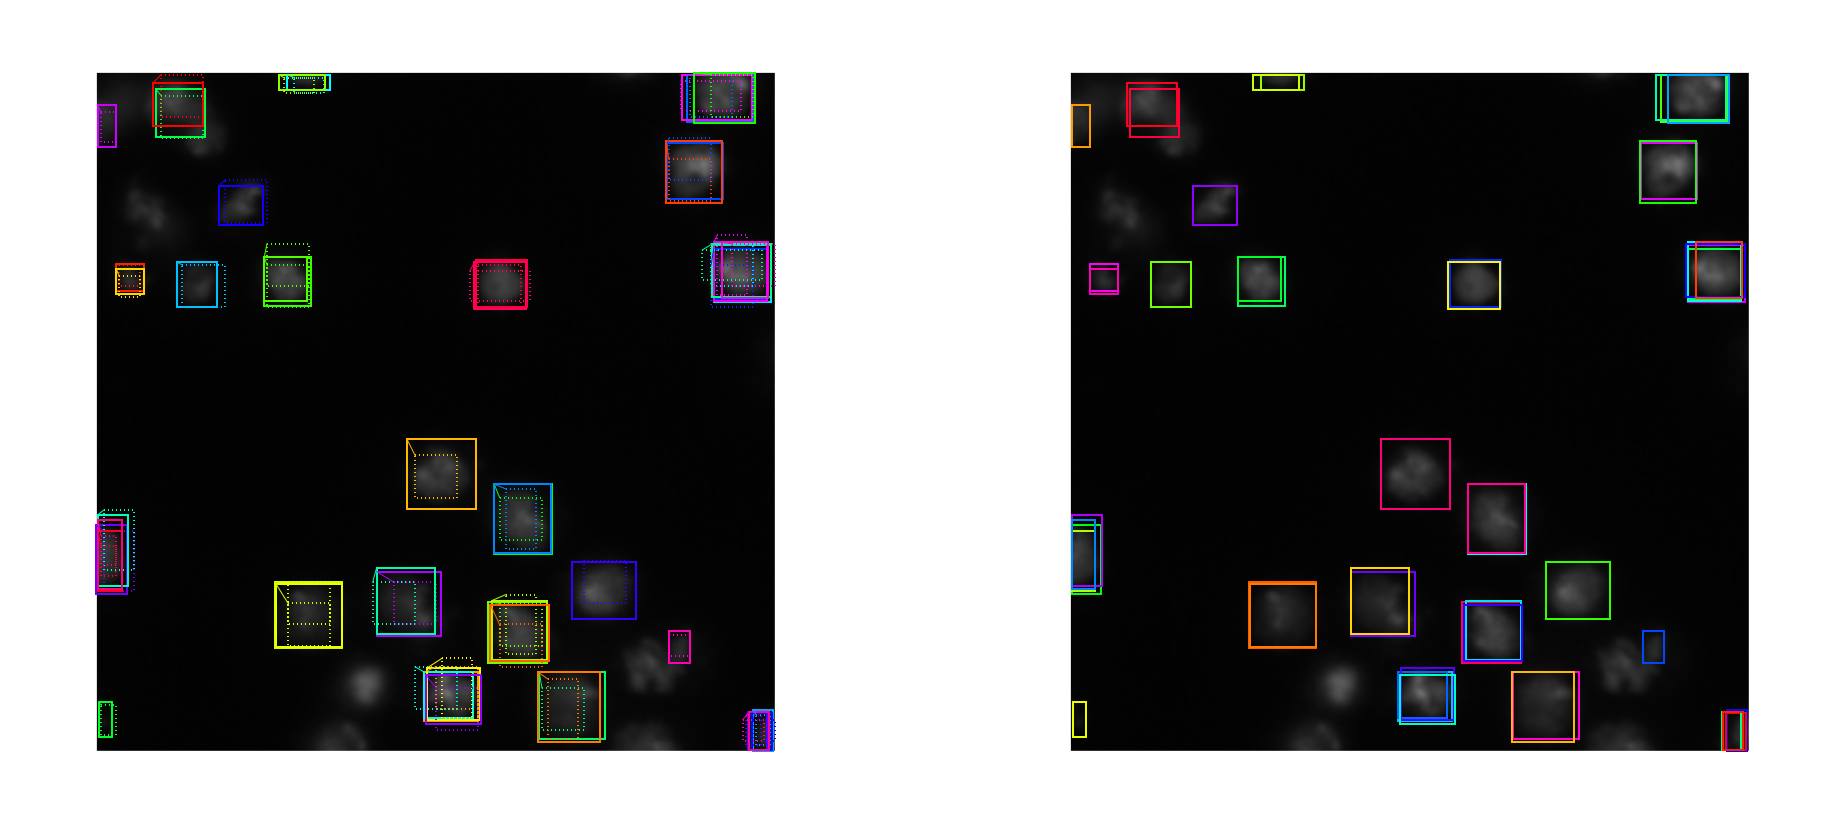

In [55]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

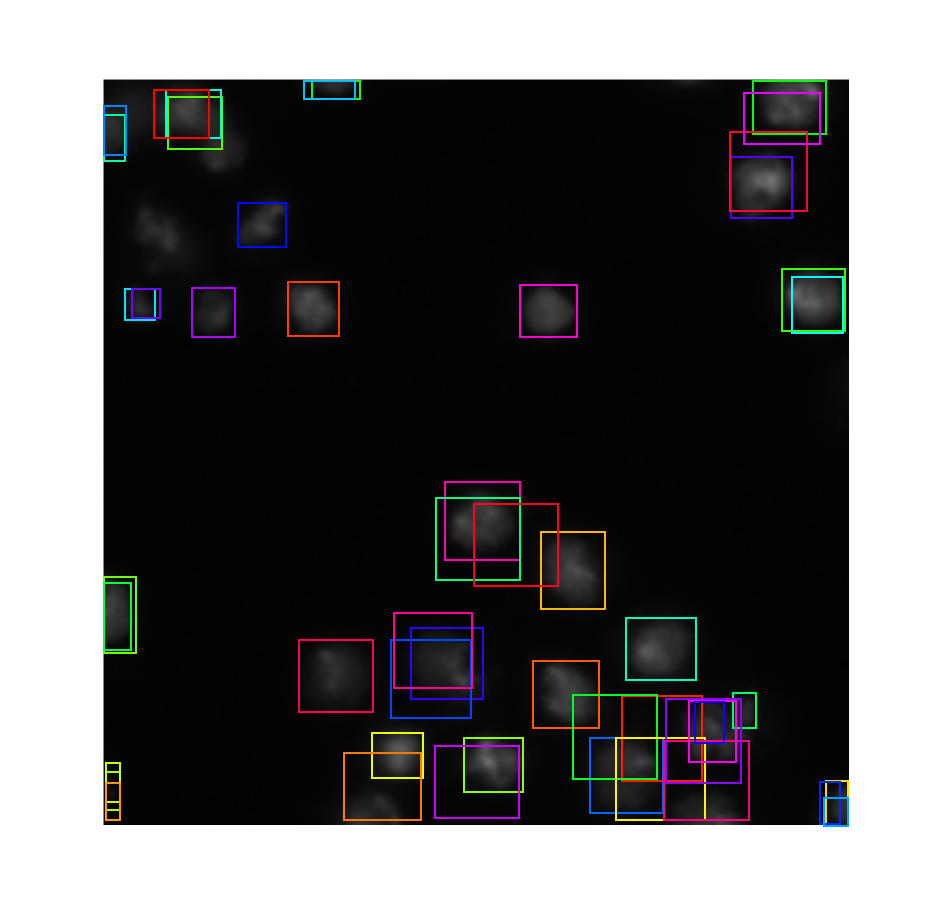

In [56]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

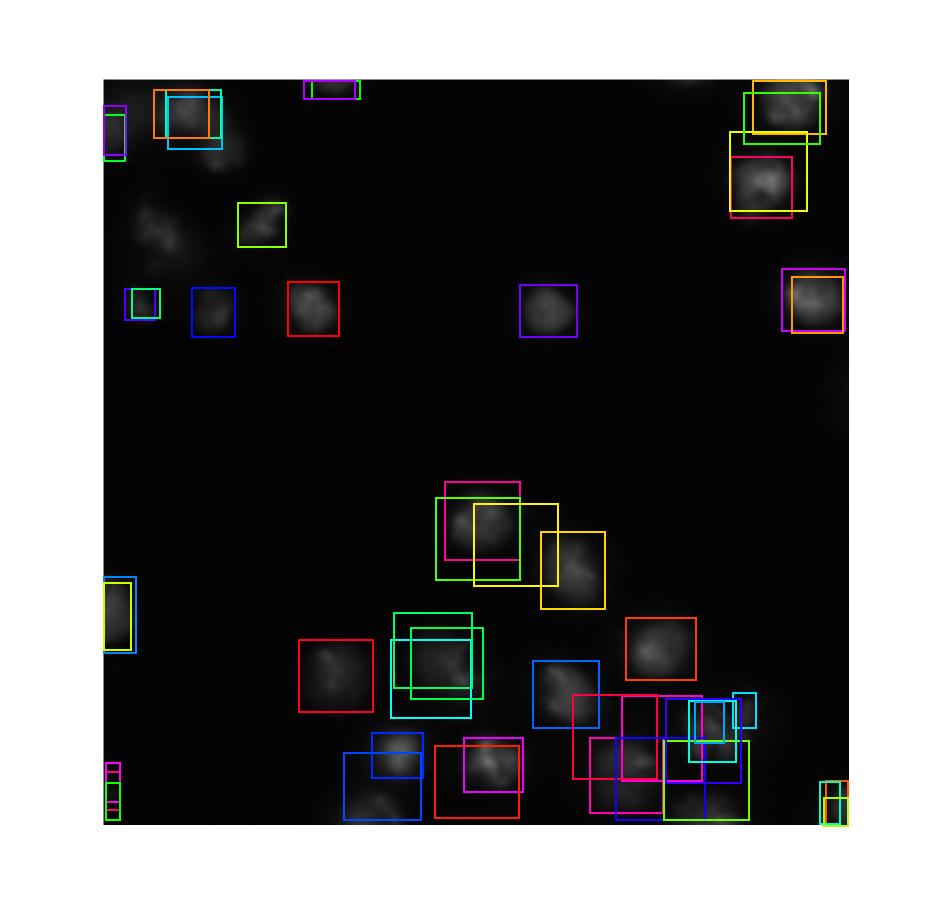

In [58]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = hs_inference_config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [59]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utl.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utl.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utl.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (65472)       Recall: 0.036  Positive anchors: 1
Refined Anchors ( 6000)   Recall: 0.643  Positive anchors: 78
Post NMS Anchors (   50)  Recall: 0.464  Positive anchors: 13


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them. I.e. Runs the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [62]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 2, 4)       min:   -5.21968  max:    4.21450
masks                    shape: (1, 512, 28, 28, 2)   min:    0.00073  max:    0.99994
detections               shape: (1, 512, 6)           min:    0.00000  max:  512.00000


29 detections: ['nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei'
 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei'
 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei'
 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei']


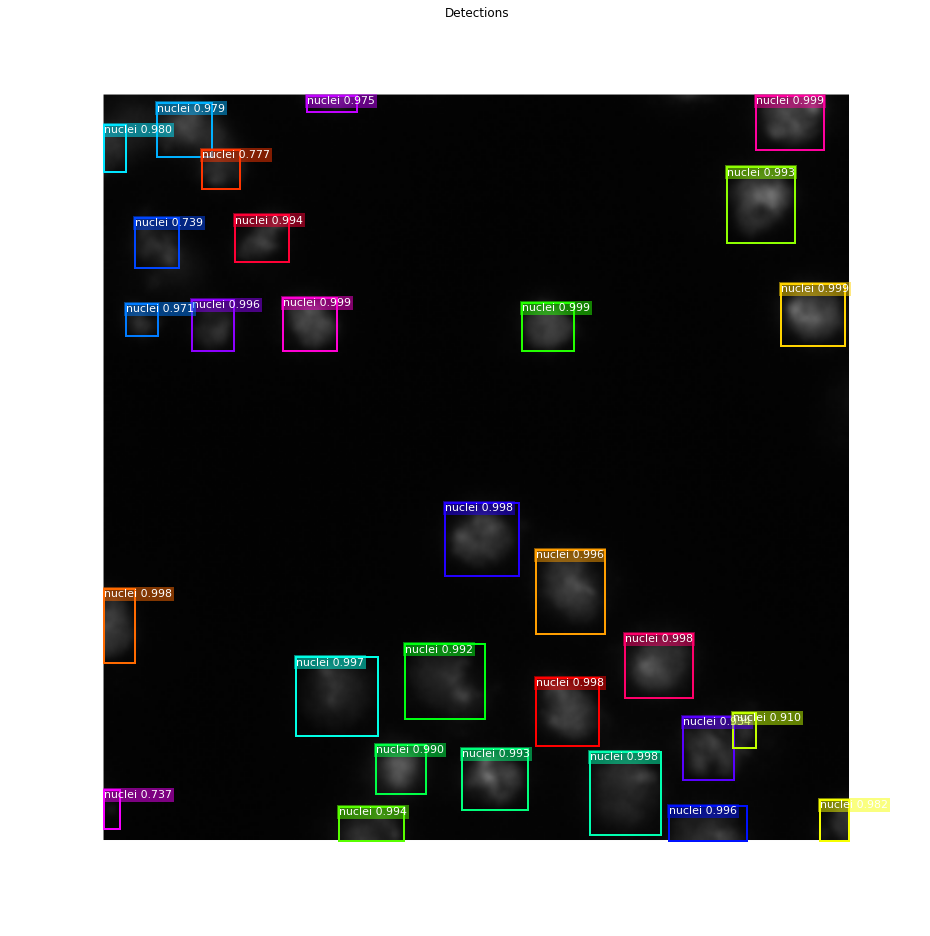

In [64]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(training_set.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(training_set.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [65]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = hs_inference_config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(training_set.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
199 Positive ROIs
[('BG', 801), ('nuclei', 199)]


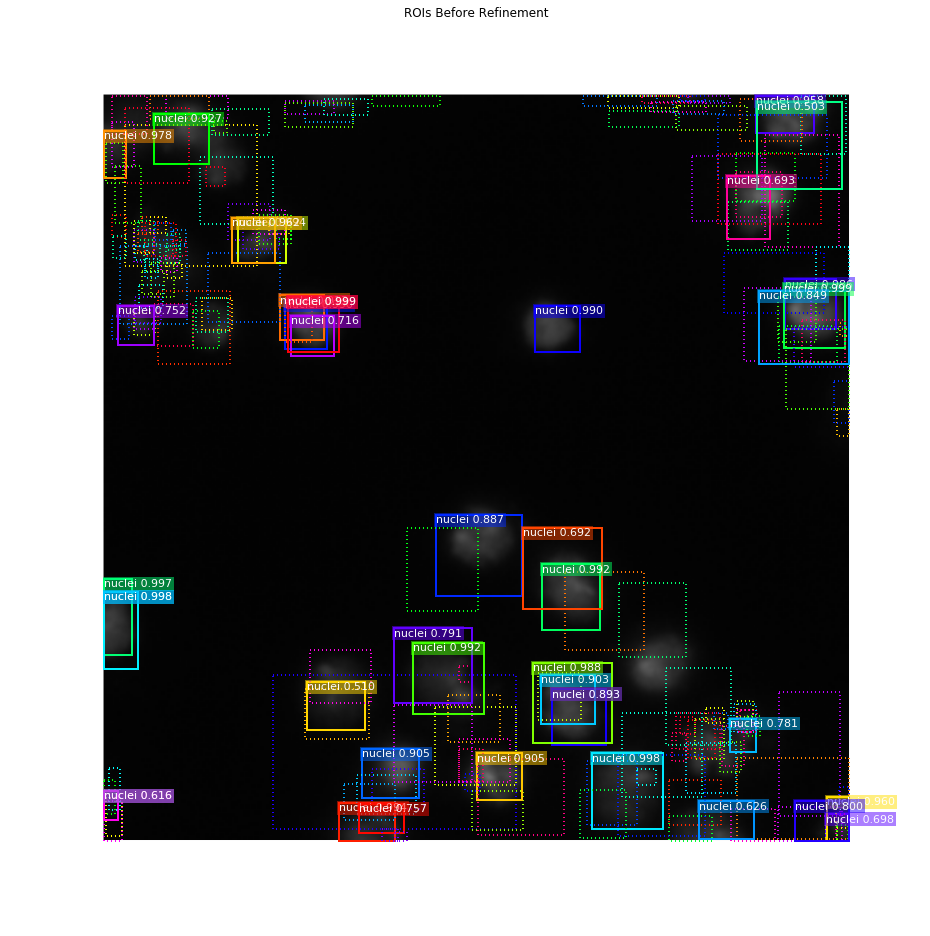

In [66]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(training_set.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -5.21968  max:    3.12627
refined_proposals        shape: (1000, 4)             min:   -3.00000  max:  515.00000


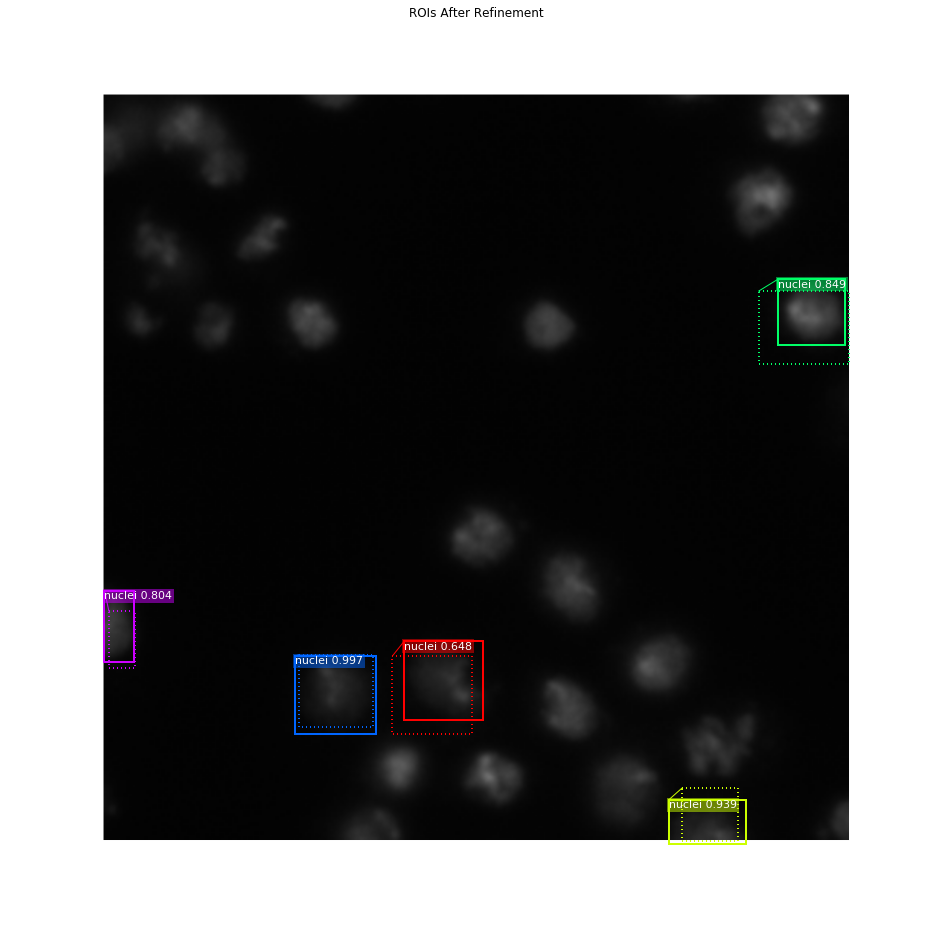

In [68]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utl.apply_box_deltas(
    proposals, roi_bbox_specific * hs_inference_config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(training_set.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [69]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 199 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  31  32  33  35  37  39  40
  43  44  49  50  51  58  59  60  61  63  64  66  67  70  71  72  75  76
  77  78  80  81  82  85  87  88  92  95  96  98 103 105 106 107 108 111
 112 113 116 122 124 130 134 136 137 139 145 147 150 151 152 153 159 160
 162 167 172 174 179 181 189 192 193 197 199 200 201 202 204 215 216 220
 229 231 232 235 237 238 239 242 245 246 257 258 260 261 262 265 272 273
 274 279 282 283 290 291 294 295 297 304 305 307 312 315 320 321 329 333
 334 337 343 345 347 348 351 352 353 357 368 369 373 380 386 388 391 393
 399 400 406 407 409 426 439 441 451 452 453 454 475 484 487 495 496 500
 502 521 525 584 585 612 634 636 729 763 781 782 783 812 829 839 880 882
 984]


In [72]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= hs_inference_config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    hs_inference_config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 163:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  25  26  27  28  31  32  33  35  39  40  43  44
  50  51  59  60  61  63  64  66  67  70  71  75  76  77  78  81  82  85
  87  92  95  96  98 103 105 106 107 108 111 112 113 116 122 130 136 137
 139 145 147 150 151 159 160 167 172 174 179 181 189 192 197 199 200 201
 202 204 220 229 231 232 235 237 238 239 242 245 246 257 258 260 262 265
 272 273 274 282 283 290 291 294 295 297 304 305 307 312 320 321 333 334
 343 345 348 351 352 353 368 373 380 386 391 399 400 406 407 426 439 441
 452 453 454 484 495 496 500 502 521 585 612 634 729 781 783 812 829 882
 984]


#### Per-Class Non-Max Suppression

In [74]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utl.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            hs_inference_config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(training_set.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

nuclei                : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  25  26  27  28  31  32  33  35  39  40  43  44
  50  51  59  60  61  63  64  66  67  70  71  75  76  77  78  81  82  85
  87  92  95  96  98 103 105 106 107 108 111 112 113 116 122 130 136 137
 139 145 147 150 151 159 160 167 172 174 179 181 189 192 197 199 200 201
 202 204 220 229 231 232 235 237 238 239 242 245 246 257 258 260 262 265
 272 273 274 282 283 290 291 294 295 297 304 305 307 312 320 321 333 334
 343 345 348 351 352 353 368 373 380 386 391 399 400 406 407 426 439 441
 452 453 454 484 495 496 500 502 521 585 612 634 729 781 783 812 829 882
 984] -> [  6   1   0   3  10   4   2   9  13  21  18   5  64   8  95  11  15  14
  44  96  33  28  81  12  39  26 172  70 495]

Kept after per-class NMS: 29
[  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  18  21  26
  28  33  39  44  64  70  81  95  96 172 495]


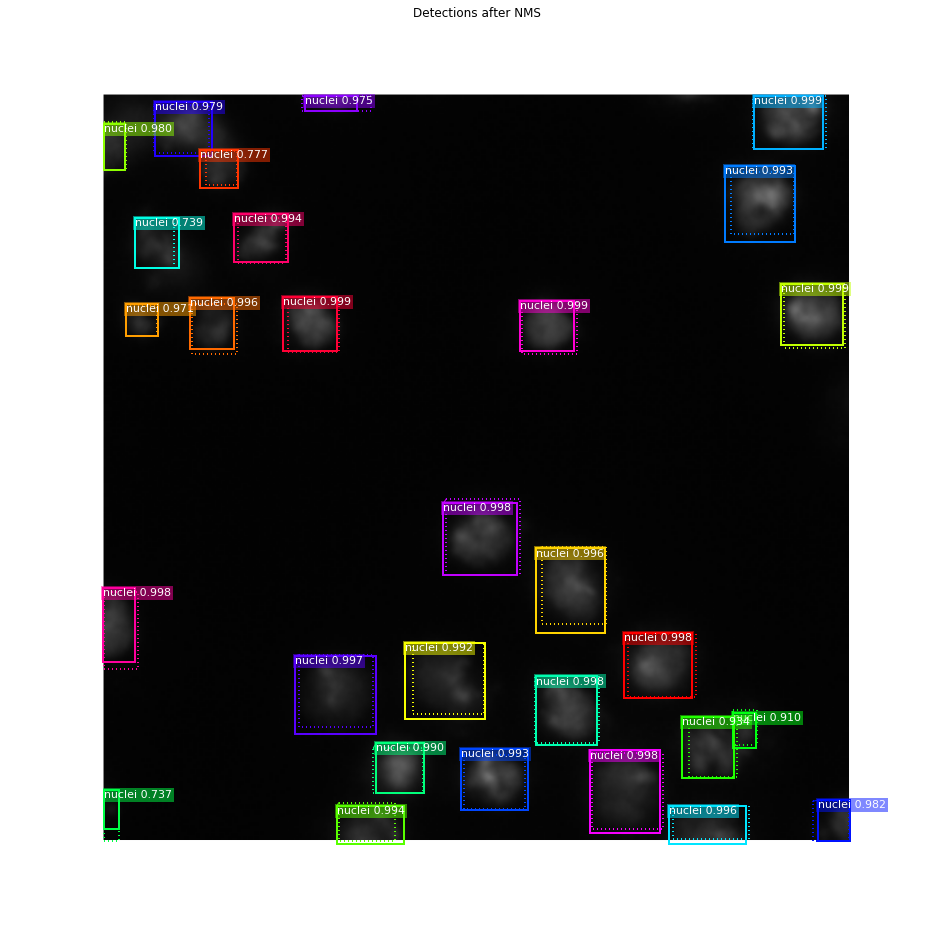

In [75]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(training_set.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

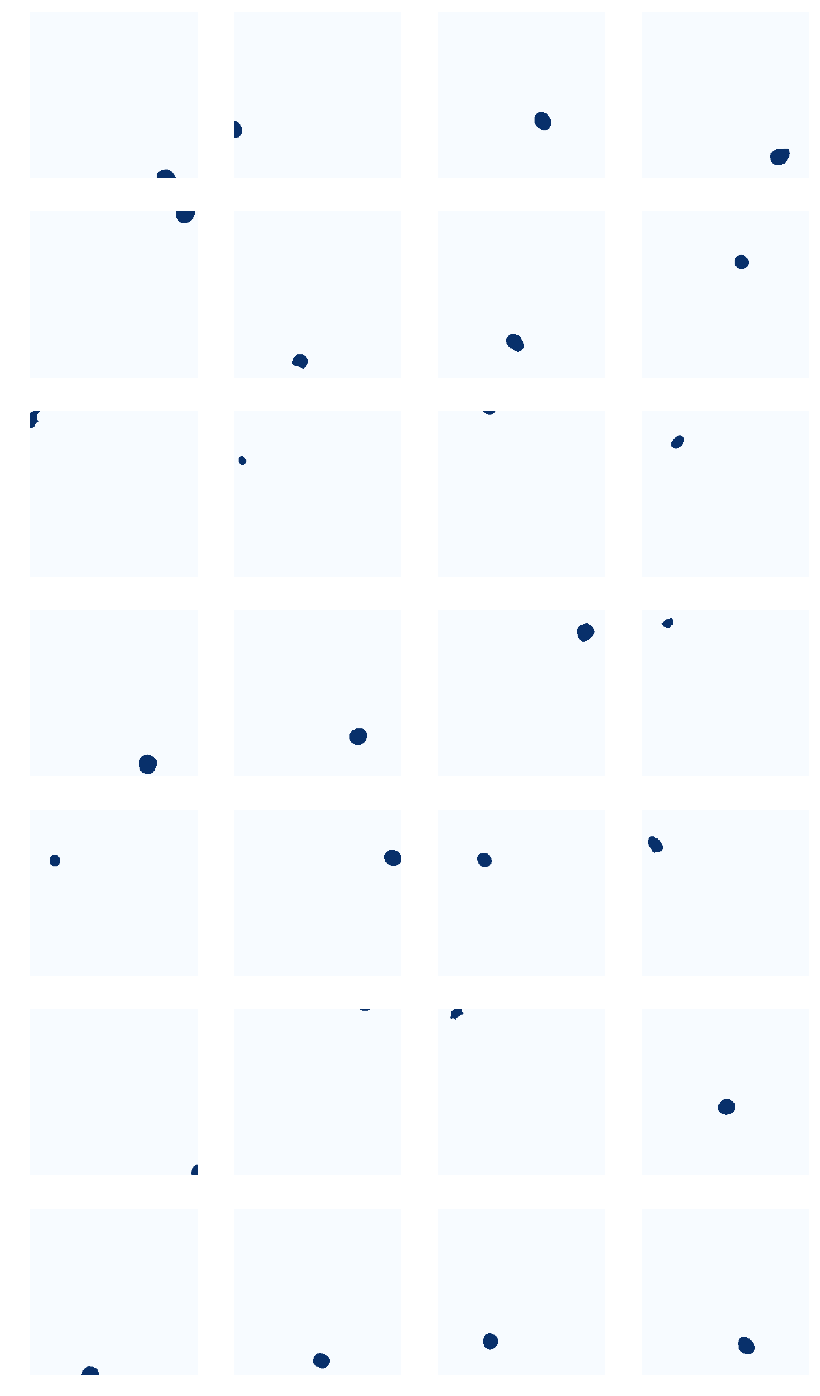

In [77]:
from visualize import display_images

display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [79]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(training_set.class_names)[det_class_ids]))

detections               shape: (1, 512, 6)           min:    0.00000  max:  512.00000
masks                    shape: (1, 512, 28, 28, 2)   min:    0.00073  max:    0.99994
29 detections: ['nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei'
 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei'
 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei'
 'nuclei' 'nuclei' 'nuclei' 'nuclei' 'nuclei']


In [80]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utl.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (29, 28, 28)          min:    0.00073  max:    0.99994
det_masks                shape: (29, 512, 512)        min:    0.00000  max:    1.00000


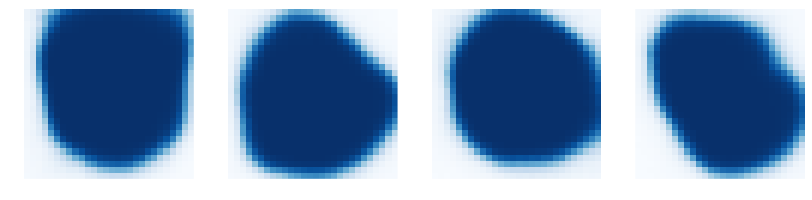

In [81]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

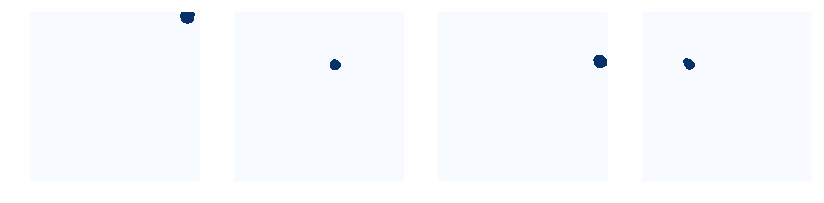

In [82]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [83]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -121.70000  max:    8.10000
res4w_out                shape: (1, 32, 32, 1024)     min:    0.00000  max:   70.41589
rpn_bbox                 shape: (1, 65472, 4)         min:   -8.12806  max:   16.82431
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


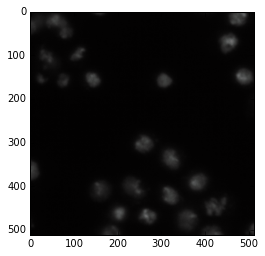

In [84]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],hs_inference_config))

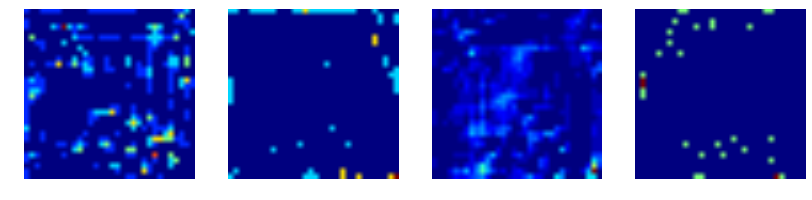

In [85]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

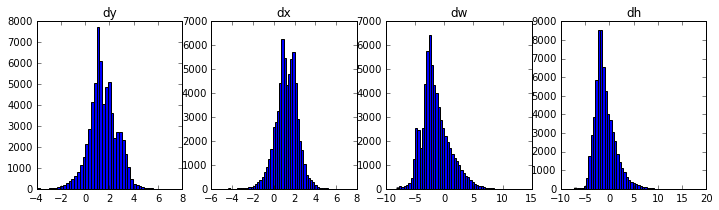

In [86]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

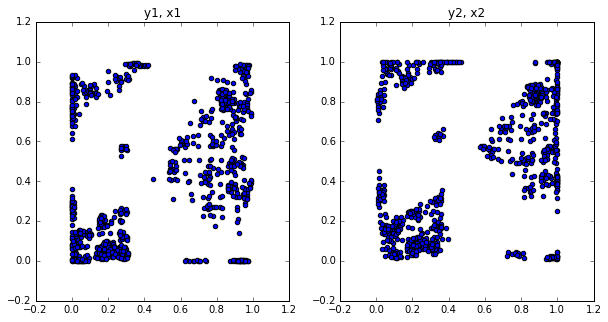

In [87]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()